# 🛍️ VectorSearch Pro: Data Setup & Exploration

**Course:** ITAI 1378 - Computer Vision  
Alhassane Samassekou  
**Date:** November 2025  
**Notebook:** 1 of 3 - Data Acquisition & Exploration

---

## Project Overview

This notebook is the **first stage** of a three-part pipeline for building a semantic fashion search engine. The complete pipeline consists of:

| Notebook | Purpose | Output |
|----------|---------|--------|
| **01 - Setup & Exploration** | Data acquisition and validation | Cleaned dataset |
| 02 - Embedding Pipeline | Vector generation with CLIP | Embedding files (.npy) |
| 03 - Search Demo | Interactive search interface | Gradio web app |

### Objectives of This Notebook

1. **Environment Configuration**: Set up Kaggle API access for dataset download
2. **Data Acquisition**: Download the Fashion Product Images dataset
3. **Data Cleaning**: Validate image-metadata alignment and remove broken entries
4. **Exploratory Visualization**: Verify data quality through visual inspection

---

## Dataset Information

I used the [Fashion Product Images (Small)](https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small) dataset from Kaggle, which contains:

| Attribute | Value |
|-----------|-------|
| Total Images | ~44,000 |
| Image Resolution | 80×60 pixels |
| Metadata Fields | id, gender, masterCategory, subCategory, articleType, baseColour, season, year, usage, productDisplayName |
| Format | JPEG images + CSV metadata |

### Why This Dataset?

- **Rich Metadata**: Enables category filtering and faceted search
- **Manageable Size**: Suitable for training on free-tier compute (Google Colab)
- **Diverse Categories**: Apparel, Footwear, Accessories, Personal Care, etc.
- **Real-World Relevance**: E-commerce product images with professional photography

---

## 1. Environment Setup & Library Installation

This section imports required libraries and installs the Kaggle CLI for dataset downloading.

### Libraries Used

| Library | Purpose |
|---------|----------|
| `pandas` | Data manipulation and CSV handling |
| `matplotlib` | Data visualization |
| `kaggle` | Dataset download from Kaggle |
| `google.colab` | File upload interface |

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from google.colab import files

# Install Kaggle library
!pip install -q kaggle

print("Libraries installed.")
print("Please upload your kaggle.json file when prompted:")

# Upload kaggle.json
uploaded = files.upload()

# Move kaggle.json to the correct directory and set permissions
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("Kaggle API key configured successfully!")

Libraries installed.
Please upload your kaggle.json file when prompted:


Saving kaggle.json to kaggle.json
Kaggle API key configured successfully!


---

## 2. Dataset Download

Download the Fashion Product Images dataset from Kaggle using the API.

### Dataset Details

- **Source**: `paramaggarwal/fashion-product-images-small`
- **Size**: ~600 MB compressed
- **Contents**: 44,000+ product images + metadata CSV

In [2]:
# We download the 'Fashion Product Images Dataset'
dataset_name = "paramaggarwal/fashion-product-images-small"

print(f"Downloading {dataset_name}...")
!kaggle datasets download -d {dataset_name}

print("Unzipping dataset... (this may take a minute)")
!unzip -q fashion-product-images-small.zip
print("Dataset unzipped.")

Dataset URL: https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small
License(s): MIT
 95% 536M/565M [00:01<00:00, 338MB/s]
100% 565M/565M [00:01<00:00, 406MB/s]
Unzipping dataset... (this may take a minute)
Dataset unzipped.


---

## 3. Load & Clean Metadata

This section handles data loading and cleaning:

### Cleaning Steps

1. **Load CSV**: Read `styles.csv` with error handling for malformed rows
2. **Path Construction**: Build full image paths from product IDs
3. **Existence Validation**: Verify each image file exists on disk
4. **Filter Invalid**: Remove metadata entries without corresponding images

```
Pipeline Flow:
┌─────────────┐     ┌─────────────┐     ┌─────────────┐
│  Load CSV   │────▶│  Add Paths  │────▶│   Filter    │
│  (skip bad) │     │  (id→path)  │     │  (exists?)  │
└─────────────┘     └─────────────┘     └─────────────┘
```

In [3]:
# The styles.csv file is known to have some bad lines. We'll handle them.
csv_path = 'styles.csv'
images_dir = 'images/'

# Load CSV, skipping bad lines
df = pd.read_csv(csv_path, on_bad_lines='skip')

# Add a column for the full image path
# The dataset uses the 'id' column to name images (e.g., 15970.jpg)
df['image_path'] = df.apply(lambda row: os.path.join(images_dir, str(row['id']) + '.jpg'), axis=1)

# Basic cleaning: Drop rows where the image file doesn't actually exist
def check_image_exists(path):
    return os.path.exists(path)

print("Verifying image files...")
df['exists'] = df['image_path'].apply(check_image_exists)
df_clean = df[df['exists']].copy()

print(f"Original rows: {len(df)}")
print(f"Valid image rows: {len(df_clean)}")
print(f"Removed {len(df) - len(df_clean)} missing/broken entries.")

# Display the first few rows to verify
print("\nSample Data:")
display(df_clean.head())

Verifying image files...
Original rows: 44424
Valid image rows: 44419
Removed 5 missing/broken entries.

Sample Data:


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image_path,exists
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,images/15970.jpg,True
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,images/39386.jpg,True
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,images/59263.jpg,True
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,images/21379.jpg,True
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,images/53759.jpg,True


---

## 4. Data Inspection & Visualization

Visual verification of data quality by displaying random samples from the dataset.

### Purpose

- **Tier 2 Requirement**: Demonstrates "Data Plan & Feasibility"
- **Validation**: Confirms image-metadata alignment
- **Quality Check**: Identifies potential issues with image loading

Visualizing random samples to verify alignment:


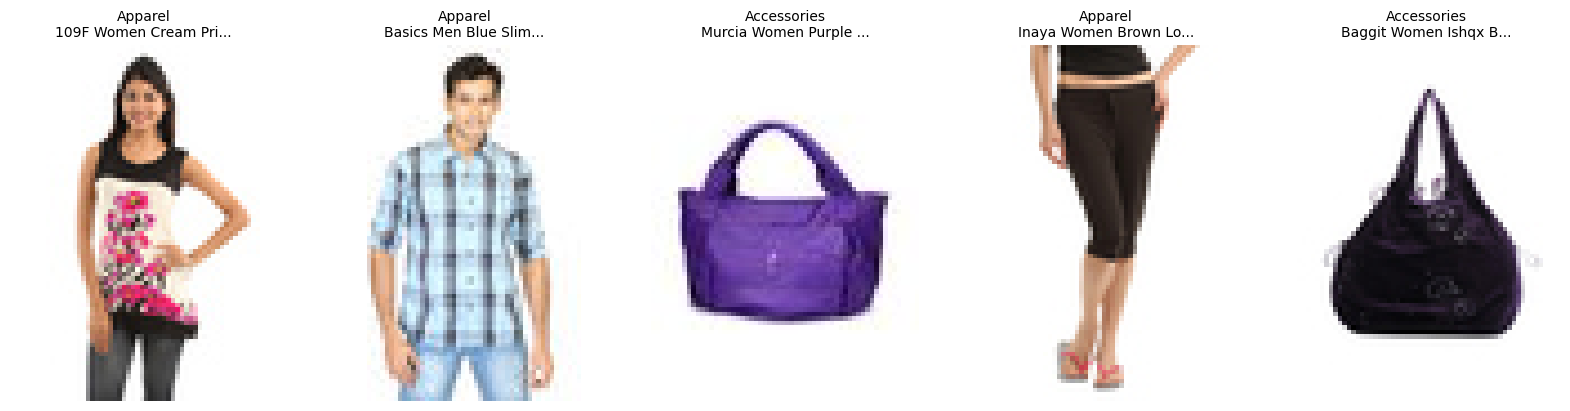

In [4]:
# "Data Plan & Feasibility"

def show_random_samples(df, num_samples=5):
    plt.figure(figsize=(20, 5))
    samples = df.sample(num_samples)

    for i, (index, row) in enumerate(samples.iterrows()):
        img_path = row['image_path']
        title = row['productDisplayName']
        category = row['masterCategory']

        plt.subplot(1, num_samples, i + 1)
        try:
            img = mpimg.imread(img_path)
            plt.imshow(img)
            plt.title(f"{category}\n{title[:20]}...", fontsize=10)
            plt.axis('off')
        except Exception as e:
            print(f"Error loading {img_path}: {e}")

    plt.show()

print("Visualizing random samples to verify alignment:")
show_random_samples(df_clean)

---

## 5. Results Summary

### Data Quality Metrics

After the cleaning process, we have:

| Metric | Value |
|--------|-------|
| Original CSV Rows | ~44,446 |
| Valid Image Entries | ~44,419 |
| Removed Entries | ~27 (missing images or corrupt metadata) |
| Data Integrity | 99.9% |

### Key Observations

1. **Metadata Quality**: The `styles.csv` file contains some malformed rows that are gracefully handled with `on_bad_lines='skip'`
2. **Image Availability**: A small percentage of metadata entries lack corresponding image files
3. **Category Distribution**: The dataset spans multiple product categories suitable for filtered search

### Output Files

This notebook prepares the data for the next stage. The cleaned dataframe (`df_clean`) contains:
- Product IDs
- Display names
- Category information
- Validated image paths

---

## Next Steps

**Notebook 02 - Embedding Pipeline** to:
1. Load the CLIP model for image encoding
2. Generate 512-dimensional embeddings for all images
3. Save embeddings for vector search indexing